# Examen Python Data Developer
# Deel 2

Ga verder met de verwerkte data die je uit deel 1 hebt. We gaan nu op basis van dezelfde dataset een aantal onderzoeksvragen oplossen!

## Imports

In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import json
from scipy.stats import norm
from scipy.interpolate import interp1d
import datetime
from tqdm import tqdm

## Read in (df_total)

In [225]:
# Directory containing the CSV files
loc=os.path.join('..','data')
# List maken voor df's
lst = []
# itereren
for filename in os.listdir(loc):
    if filename.endswith('.csv'):
        
        # extractie datum naam
        date_str = filename.split('.')[0]
        
        #filepath vastzetten
        file_path=os.path.join(loc, filename)
        
        #csv inlezen an df maken
        df=pd.read_csv(file_path)
        
        #datum kolom aan toevoegen
        df['datum']=date_str
        
        #kleine dataframes klaar per stuk, nu appenden in de lijst
        lst.append(df)
        
# lijst van df's concatineren to 1 DF
df_total=pd.concat(lst, ignore_index=True)

In [226]:
df_total

,gemeente,naam,geslacht,verwachte datum,datum
0,Hooglede,Elias,Mannelijk,01/14/2019,2019-1-1
1,Sint-Niklaas (Sint-Niklaas),Pauline,Vrouwelijk,01/05/2019,2019-1-1
2,Wijnegem,Anita,Vrouwelijk,01/05/2019,2019-1-1
3,Grâce-Hollogne,Jean-Paul,Mannelijk,01/13/2019,2019-1-1
4,Boussu,François,Mannelijk,01/26/2019,2019-1-1
...,...,...,...,...,...
116918,Lede,Lobke,Vrouwelijk,09/12/2019,2019-9-9
116919,Westerlo,Willem,Mannelijk,09/04/2019,2019-9-9
116920,Brugge,Diane,Vrouwelijk,09/20/2019,2019-9-9
116921,Lendelede,Marie-Rose,Vrouwelijk,10/28/2019,2019-9-9


In [227]:
#df_total.to_csv('df_total.csv', index=False)

## Preprocess (functie voor het bekomen van: df_clean en df_wrong)

In [228]:
def clean_df(df):
    
    """
    Reinigt de DataFrame door outlier-datums te verwijderen, datumkolommen te converteren (datetimeobjecten),
    en dag- en maandnamen te categoriseren. Retourneert de gereinigde DataFrame alsook df_wrong.
    """
    
    # df_wrong met verkeerde datum (29 februari)
    outlier_datums = ['2019-2-29', '2019-1-1', '2019-7-1']
    df_wrong = df.loc[df['datum'].isin(outlier_datums)].copy()

    # Verwijder rijen met verkeerde datums
    df = df.loc[~df['datum'].isin(outlier_datums)].copy()
    df = df.reset_index(drop=True)
    
    # omzetten tot datetimes
    df['dag van het jaar'] = pd.to_datetime(df['datum']).dt.dayofyear
    df['verwachte datum'] = pd.to_datetime(df['verwachte datum'], format='%m/%d/%Y') # .dt.strftime('%Y-%m-%d')
    df['datum'] = pd.to_datetime(df['datum']) # .dt.strftime('%Y-%m-%d')

    # Define day and month categories
    day_categories = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    month_categories = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

    # Convert 'Day of Week' tot category: efficienter en zinvol (eg sorteringen dagen niet meer alfabetisch, maar volgens orde)
    df['weekdag'] = pd.to_datetime(df['datum']).dt.day_name()
    df['weekdag'] = pd.Categorical(df['weekdag'], categories=day_categories, ordered=True)

    # Add month name and categorize it
    df['maand'] = pd.to_datetime(df['datum']).dt.strftime('%B')
    df['maand'] = pd.Categorical(df['maand'], categories=month_categories, ordered=True)
    
    # Calculate the difference in days between 'verwachte datum' and 'datum'
    df['verschil_dagen'] = (df['verwachte datum'] - df['datum']).dt.days

    return df, df_wrong

In [230]:
df_clean, df_wrong=clean_df(df_total)

In [231]:
df_clean

,gemeente,naam,geslacht,verwachte datum,datum,dag van het jaar,weekdag,maand,verschil_dagen
0,Merksplas,Liliane,Vrouwelijk,2019-01-04,2019-01-10,10,Thursday,January,-6
1,Bornem,Jeroen,Mannelijk,2019-01-10,2019-01-10,10,Thursday,January,0
2,Houthalen-Helchteren,Fatima,Vrouwelijk,2019-01-21,2019-01-10,10,Thursday,January,11
3,Lievegem,Hilaire,Mannelijk,2019-01-15,2019-01-10,10,Thursday,January,5
4,Spiere-Helkijn,Christian,Mannelijk,2019-01-16,2019-01-10,10,Thursday,January,6
...,...,...,...,...,...,...,...,...,...
115388,Lede,Lobke,Vrouwelijk,2019-09-12,2019-09-09,252,Monday,September,3
115389,Westerlo,Willem,Mannelijk,2019-09-04,2019-09-09,252,Monday,September,-5
115390,Brugge,Diane,Vrouwelijk,2019-09-20,2019-09-09,252,Monday,September,11
115391,Lendelede,Marie-Rose,Vrouwelijk,2019-10-28,2019-09-09,252,Monday,September,49


In [232]:
df_wrong

,gemeente,naam,geslacht,verwachte datum,datum
0,Hooglede,Elias,Mannelijk,01/14/2019,2019-1-1
1,Sint-Niklaas (Sint-Niklaas),Pauline,Vrouwelijk,01/05/2019,2019-1-1
2,Wijnegem,Anita,Vrouwelijk,01/05/2019,2019-1-1
3,Grâce-Hollogne,Jean-Paul,Mannelijk,01/13/2019,2019-1-1
4,Boussu,François,Mannelijk,01/26/2019,2019-1-1
...,...,...,...,...,...
87731,Oostende,Magali,Vrouwelijk,07/15/2019,2019-7-1
87732,Rotselaar,Jean,Mannelijk,06/30/2019,2019-7-1
87733,Brussel,Lina,Vrouwelijk,07/11/2019,2019-7-1
87734,Hamont-Achel,Brenda,Vrouwelijk,06/25/2019,2019-7-1


In [233]:
##############################################     Let's go!       ##########################################################

### Onderzoek 1: Unisex namen
#### Een aantal statistieken
Sommige namen zijn unisex, dat wil zeggen dat zij hetzelfde zijn voor mannen en vrouwen. Beantwoord volgende 3 vragen over unisex namen in onze dataset:
 - Hoeveel unisex namen zijn er?
 - Wat is de meest voorkomende unisex naam; hiervoor zoek ik 3 namen (en getallen):
    - De meest populaire unisex naam bij mannen.
    - De meest populaire unisex naam bij vrouwen.
    - De meest popuaire unisex naam.

**Tip:** Neem hiervoor terug de volledige dataset in acht (dus met de foutief geklasseerde namen).

In [234]:
df_total.head()

,gemeente,naam,geslacht,verwachte datum,datum
0,Hooglede,Elias,Mannelijk,01/14/2019,2019-1-1
1,Sint-Niklaas (Sint-Niklaas),Pauline,Vrouwelijk,01/05/2019,2019-1-1
2,Wijnegem,Anita,Vrouwelijk,01/05/2019,2019-1-1
3,Grâce-Hollogne,Jean-Paul,Mannelijk,01/13/2019,2019-1-1
4,Boussu,François,Mannelijk,01/26/2019,2019-1-1


In [235]:
#group naam en en kijk naar nuniques
geslacht_grouped_name=df_total.groupby('naam')['geslacht'].nunique()
unisex_namen=geslacht_grouped_name[geslacht_grouped_name > 1].index.tolist()

#filter enkel unisex namen
df_unisex = df_total[df_total['naam'].isin(unisex_namen)]

In [236]:
#Hoeveel zijn er unisex namen zijn er?
num_unisex_names = len(unisex_namen)
num_unisex_names

75

In [237]:
#meest voor komende mannelijk:
man_unisex = df_unisex[df_unisex['geslacht'] == 'Mannelijk']['naam'].value_counts().idxmax()
man_unisex

'Maxime'

In [238]:
#meest voorkomende vrouwelijke:
vrouw_unisex = df_unisex[df_unisex['geslacht'] == 'Vrouwelijk']['naam'].value_counts().idxmax()
vrouw_unisex

'Dominique'

In [239]:
#de meest populaire unisex naam:
df_unisex['naam'].value_counts().idxmax()

'Dominique'

We zien dat er een vrij groot aantal namen veel meer voorkomen bij mannen dan vrouwen (en omgekeerd). Dit vinden we eigenlijk geen "echte" unisex namen. We noemen een naam "echt unisex" als de naam niet meer dan 50% meer voorkomt bij 1 van de 2 geslachten. Dus als er `x` mannen en `y` vrouwen zijn genaamd Chris, dan noemen we Chris "echt unisex" als `x <= 1.5 * y` en `y <= x * 1.5`. Filter je unisex dataframe tot een `df_real_unisex` waarbij je enkel de "echte" unisex namen weerhoudt. 
- Beantwoord nu bovenstaande 3 vragen opnieuw voor deze dataset. Hierbij werk je best met een functie zodat je geen code moet herhalen!
- Zijn de echte unisex namen populairder bij mannen of vrouwen, of is de populariteit hetzelfde? Deze vraag kan je beantwoorden door te kijken naar het percentage mannen/vrouwen met een echte unisex naam.

In [240]:
# group naam en tel aantal for elk geslacht
name_gender_counts = df_total.groupby(['naam', 'geslacht']).size().unstack(fill_value=0) #nan's vervangen door 0
name_gender_counts

geslacht,Mannelijk,Vrouwelijk
naam,,
Aaron,45,0
Aaya,0,1
Abbas,2,0
Abdallah,3,0
Abdel,5,0
...,...,...
Özge,0,2
Özgür,2,0
Özkan,2,0


In [241]:
#filter om enkel echt unisex te hebben
df_real_unisex_names = name_gender_counts[
        (name_gender_counts['Mannelijk'] <= 1.5 * name_gender_counts['Vrouwelijk']) &
        (name_gender_counts['Vrouwelijk'] <= 1.5 * name_gender_counts['Mannelijk'])
    ].index.tolist()
df_real_unisex_names

['Beau',
 'Deniz',
 'Dominique',
 'Dursun',
 'Gabriele',
 'Isa',
 'Joni',
 'Niki',
 'Noa',
 'Senna',
 'Vivian',
 'Yan',
 'Yi',
 'Yoni']

In [242]:
# Filter the dataframe met enkel echte unisex namen:
df_real_unisex = df_total[df_total['naam'].isin(df_real_unisex_names)]
df_real_unisex

,gemeente,naam,geslacht,verwachte datum,datum
386,Tielt (Tielt),Dominique,Vrouwelijk,01/08/2019,2019-1-1
568,Sint-Lambrechts-Woluwe,Dominique,Vrouwelijk,01/11/2019,2019-1-10
671,Schaarbeek,Deniz,Mannelijk,01/18/2019,2019-1-10
768,Brakel,Dominique,Vrouwelijk,01/21/2019,2019-1-10
939,Wevelgem,Dominique,Mannelijk,01/08/2019,2019-1-11
...,...,...,...,...,...
115962,Marche-en-Famenne,Dominique,Mannelijk,09/09/2019,2019-9-6
116012,Chaudfontaine,Dominique,Mannelijk,09/21/2019,2019-9-7
116173,Puurs-Sint-Amands,Dominique,Mannelijk,09/30/2019,2019-9-7
116596,Libin,Dominique,Vrouwelijk,09/22/2019,2019-9-8


In [243]:
#aantal
num_real_unisex_names = len(df_real_unisex_names)
num_real_unisex_names

14

In [244]:
#male:
most_common_male_real = df_real_unisex[df_real_unisex['geslacht'] == 'Mannelijk']['naam'].value_counts().idxmax()
most_common_male_real

'Dominique'

In [245]:
#female:
most_common_female_real = df_real_unisex[df_real_unisex['geslacht'] == 'Vrouwelijk']['naam'].value_counts().idxmax()
most_common_female_real

'Dominique'

In [246]:
#meest populaire:
most_common_real_unisex = df_real_unisex['naam'].value_counts().idxmax()
most_common_real_unisex

'Dominique'

In [247]:
#percentage
total_males_real = df_real_unisex[df_real_unisex['geslacht'] == 'Mannelijk'].shape[0]
total_males_real

226

In [248]:
total_females_real = df_real_unisex[df_real_unisex['geslacht'] == 'Vrouwelijk'].shape[0]
total_females_real

288

In [249]:
total_real_unisex = df_real_unisex.shape[0]
total_real_unisex

514

In [250]:
#totaal aantal mannen in onze df_total
df_total['geslacht'].value_counts()

geslacht
Mannelijk     58964
Vrouwelijk    57959
Name: count, dtype: int64

In [251]:
per_males= (total_males_real/df_total['geslacht'].value_counts()[0]) * 100
per_males
#0.4%

C:\Users\emmer\AppData\Local\Temp\ipykernel_25652\3781814003.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  per_males= (total_males_real/df_total['geslacht'].value_counts()[0]) * 100


0.38328471609795806

In [252]:
perc_females= (total_females_real/df_total['geslacht'].value_counts()[1]) * 100
perc_females
#0.5%

C:\Users\emmer\AppData\Local\Temp\ipykernel_25652\2353591184.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  perc_females= (total_females_real/df_total['geslacht'].value_counts()[1]) * 100


0.4969029831432564

In [253]:
#er zijn meer Vrouwen met een Unisex naam dan Mannen

In [254]:
#df_real_unisex.to_csv('df_real_unisex.csv', index=False)

#### Visualizatie

Maak een visualizatie die alle echte unisex namen toont en de relatieve voorkomens bij mannen en vrouwen.

In [255]:
#Visualisatie (geen tijd om te sorteren, sorry :( )

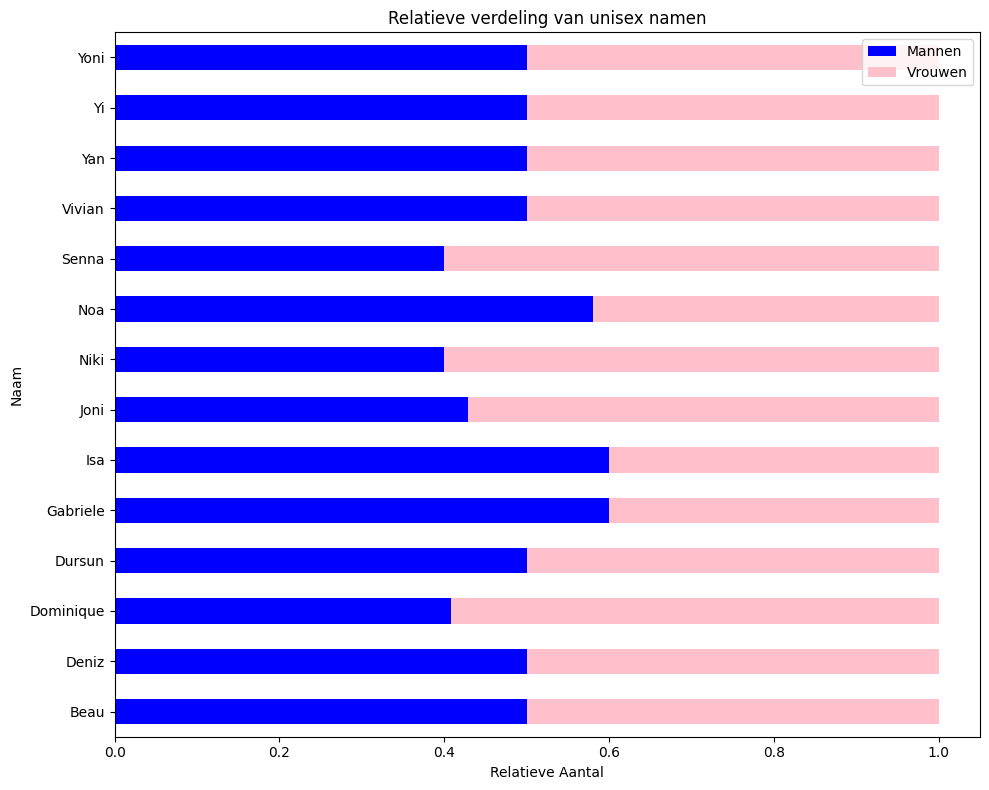

In [256]:
# Group by 'naam' and 'geslacht', then count occurrences
grouped_df_real_unisex = df_real_unisex.groupby(['naam', 'geslacht']).size().unstack(fill_value=0)

# Ensure 'Mannelijk' and 'Vrouwelijk' are columns, even if there are no occurrences
if 'Mannelijk' not in grouped_df_real_unisex.columns:
    grouped_df_real_unisex['Mannelijk'] = 0
if 'Vrouwelijk' not in grouped_df_real_unisex.columns:
    grouped_df_real_unisex['Vrouwelijk'] = 0

# Calculate the relative occurrences
grouped_df_real_unisex['Total'] = grouped_df_real_unisex['Mannelijk'] + grouped_df_real_unisex['Vrouwelijk']
grouped_df_real_unisex['Mannelijk_Relative'] = grouped_df_real_unisex['Mannelijk'] / grouped_df_real_unisex['Total']
grouped_df_real_unisex['Vrouwelijk_Relative'] = grouped_df_real_unisex['Vrouwelijk'] / grouped_df_real_unisex['Total']

# Filter to only include names that have both male and female occurrences
unisex_df_real_unisex = grouped_df_real_unisex[(grouped_df_real_unisex['Mannelijk'] > 0) & (grouped_df_real_unisex['Vrouwelijk'] > 0)]

# Create the relative stacked bar plot
fig, ax = plt.subplots(figsize=(10, 8))
unisex_df_real_unisex[['Mannelijk_Relative', 'Vrouwelijk_Relative']].plot(kind='barh', stacked=True, color=['blue', 'pink'], ax=ax)

# Set the title and labels
ax.set_title('Relatieve verdeling van unisex namen')
ax.set_xlabel('Relatieve Aantal')
ax.set_ylabel('Naam')

# Add legend
ax.legend(['Mannen', 'Vrouwen'])

plt.tight_layout()
plt.show()

### Onderzoek 2: de accuraatheid van de geschatte bevallingsdatum
#### Evolutie vergelijken

Maak een afbeelding van het totaal aantal geboortes per dag en het totaal aantal verwachte geboortes.

**Bonusvraag**: Gewoon om over na te denken: waarom zien de uiteindes van je plot er wat gek uit? Schrijf het antwoord neer in een strategisch geplaatste markdown cel.

In [257]:
df_clean.dtypes

gemeente                    object
naam                        object
geslacht                    object
verwachte datum     datetime64[ns]
datum               datetime64[ns]
dag van het jaar             int32
weekdag                   category
maand                     category
verschil_dagen               int64
dtype: object

In [258]:
df_clean['verwachte datum dag']=df_clean['verwachte datum'].dt.dayofyear
df_clean.head()

,gemeente,naam,geslacht,verwachte datum,datum,dag van het jaar,weekdag,maand,verschil_dagen,verwachte datum dag
0,Merksplas,Liliane,Vrouwelijk,2019-01-04,2019-01-10,10,Thursday,January,-6,4
1,Bornem,Jeroen,Mannelijk,2019-01-10,2019-01-10,10,Thursday,January,0,10
2,Houthalen-Helchteren,Fatima,Vrouwelijk,2019-01-21,2019-01-10,10,Thursday,January,11,21
3,Lievegem,Hilaire,Mannelijk,2019-01-15,2019-01-10,10,Thursday,January,5,15
4,Spiere-Helkijn,Christian,Mannelijk,2019-01-16,2019-01-10,10,Thursday,January,6,16


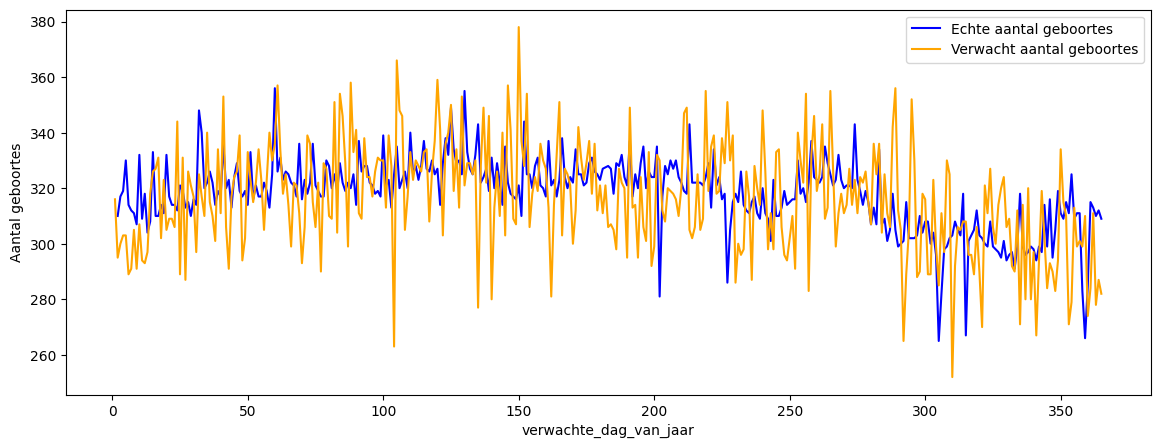

In [259]:
# Now, group by the day of the year for both actual and expected dates
actual_births_per_day= df_clean.groupby('dag van het jaar').size()
expected_births_per_day = df_clean.groupby('verwachte datum dag').size()


plt.figure(figsize=(14, 5))
plt.plot(actual_births_per_day.index, actual_births_per_day.values, label='Echte aantal geboortes', color='blue')
plt.plot(expected_births_per_day.index, expected_births_per_day.values, label='Verwacht aantal geboortes', color='orange')
plt.xlabel('verwachte_dag_van_jaar')
plt.ylabel('Aantal geboortes')
plt.legend()
plt.show()

In [260]:
#Gezien mijn data clean is, kan ik afleiden dat de pieken die naar beneden pieken te wijten zijn aan:
#missende data (kan te wijten aan te missende dat van 1 january en 1 juli)

#### Verbanden bekijken
Maak een histogram van het aantal dagen dat babies te vroeg geboren werden in 2019 en een scatterplot die het verband toont tussen de verwachte en effectieve geboortedatum.

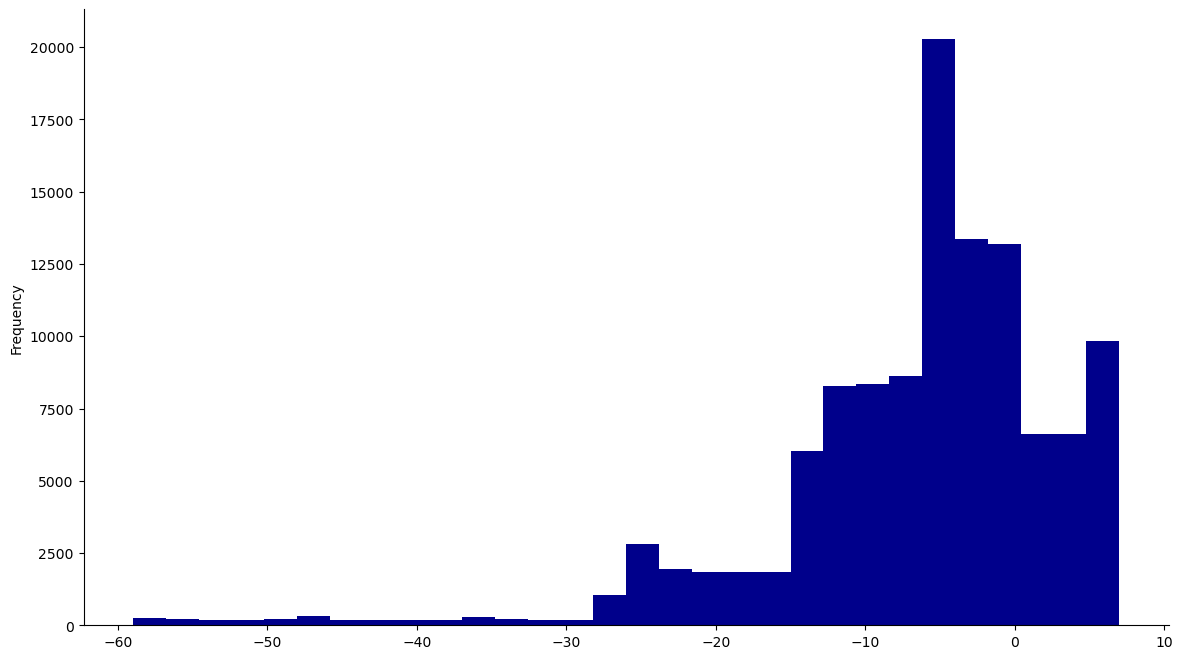

In [219]:
#kolom aanmaken
df_clean['verschil_dagen neg'] = (df_clean['datum'] - df_clean['verwachte datum']).dt.days

In [195]:
df_clean.head()

,gemeente,naam,geslacht,verwachte datum,datum,dag van het jaar,weekdag,maand,verschil_dagen,verwachte datum dag,verschil_dagen neg
0,Merksplas,Liliane,Vrouwelijk,2019-01-04,2019-01-10,10,Thursday,January,-6,4,6
1,Bornem,Jeroen,Mannelijk,2019-01-10,2019-01-10,10,Thursday,January,0,10,0
2,Houthalen-Helchteren,Fatima,Vrouwelijk,2019-01-21,2019-01-10,10,Thursday,January,11,21,-11
3,Lievegem,Hilaire,Mannelijk,2019-01-15,2019-01-10,10,Thursday,January,5,15,-5
4,Spiere-Helkijn,Christian,Mannelijk,2019-01-16,2019-01-10,10,Thursday,January,6,16,-6


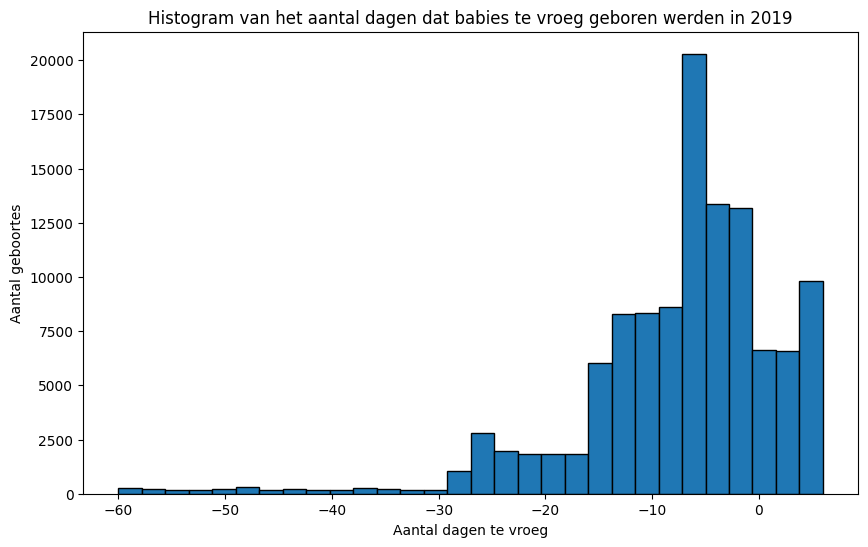

In [218]:
#histogram aantal babaies te vroeg geboren
plt.figure(figsize=(10, 6))
plt.hist(df_clean['verschil_dagen neg'], bins=30, edgecolor='black')
plt.xlabel('Aantal dagen te vroeg')
plt.ylabel('Aantal geboortes')
plt.title('Histogram van het aantal dagen dat babies te vroeg geboren werden in 2019')
plt.show()

In [197]:
#scatterplot voor verband tussen verwachte en effectieve geboorte datum

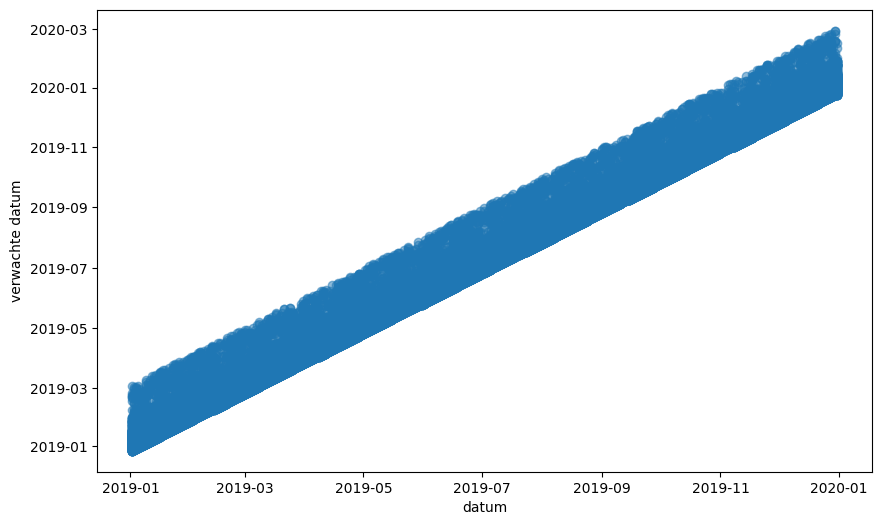

In [217]:
plt.figure(figsize=(10, 6))
plt.scatter(df_clean['datum'], df_clean['verwachte datum'], alpha=0.5)
plt.xlabel('datum')
plt.ylabel('verwachte datum')
plt.show()

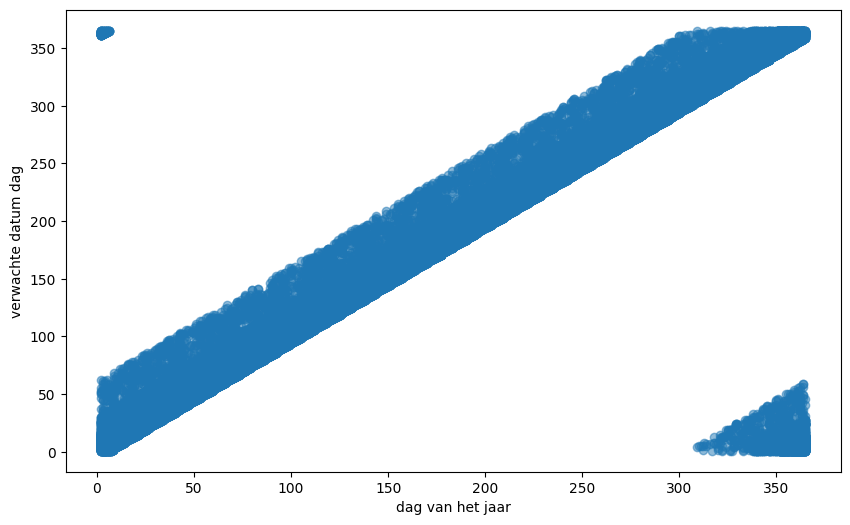

In [216]:
#met verwachte dag en dag van het jaar
plt.figure(figsize=(10, 6))
plt.scatter(df_clean['dag van het jaar'], df_clean['verwachte datum dag'], alpha=0.5)
plt.xlabel('dag van het jaar')
plt.ylabel('verwachte datum dag')

plt.show()

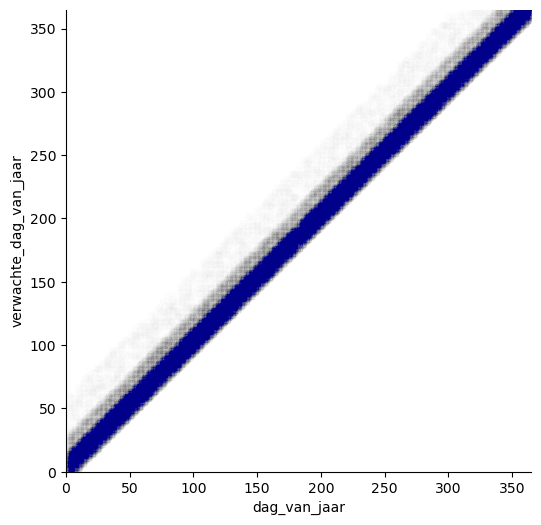

### Onderzoek 3: Aantal namen versus aantal babies
Naarmate dat er meer babies geboren worden, gaan deze ook meer verschillende namen krijgen. Zolang er weinig babies geboren worden lijkt het logisch dat dit verband min of meer lineair is, maar naarmate dat er meer en meer babies geboren worden lijkt het niet meer logisch dat dit verband lineair blijft. We verwachten bijvoorbeeld niet dat het aantal unieke namen gegeven aan 2 miljoen babies het dubbel is van het aantal unieke namen gegeven aan 1 miljoen babies. Kan je op basis van deze dataset het verband tussen het aantal unieke namen in functie van het aantal babies eens onderzoeken? Hiervoor krijg je geen voorstel tot visualizatie maar moet je zelf mij proberen te overtuigen van je antwoord.

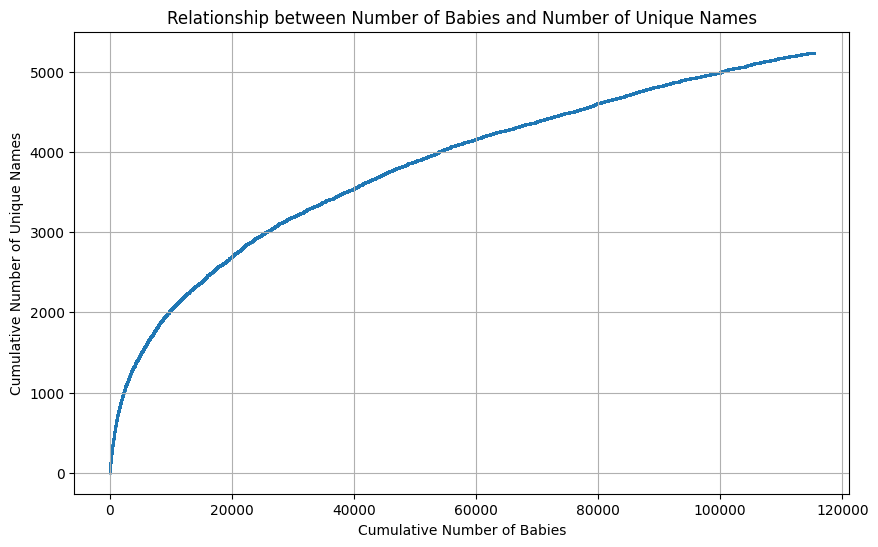

In [215]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Convert date columns to datetime format
df_clean['verwachte datum'] = pd.to_datetime(df_clean['verwachte datum'], errors='coerce')
df_clean['datum'] = pd.to_datetime(df_clean['datum'], errors='coerce')

# Sort the dataframe by the actual birth date
df_sorted = df_clean.sort_values(by='datum').reset_index(drop=True)

# Create cumulative counts for number of babies and number of unique names
df_sorted['cumulative_babies'] = df_sorted.index + 1  # assuming index represents individual births

# Calculate cumulative unique names by iterating through the data
unique_names = set()
cumulative_unique_names = []

for name in df_sorted['naam']:
    unique_names.add(name)
    cumulative_unique_names.append(len(unique_names))

df_sorted['cumulative_unique_names'] = cumulative_unique_names

# Extract the cumulative data for plotting and modeling
cumulative_babies = df_sorted['cumulative_babies'].values
cumulative_unique_names = df_sorted['cumulative_unique_names'].values

# Plotting the cumulative data
plt.figure(figsize=(10, 6))
plt.scatter(cumulative_babies, cumulative_unique_names, s=1, alpha=0.5)
plt.xlabel('Cumulative Number of Babies')
plt.ylabel('Cumulative Number of Unique Names')
plt.title('Relationship between Number of Babies and Number of Unique Names')
plt.grid(True)
plt.show()

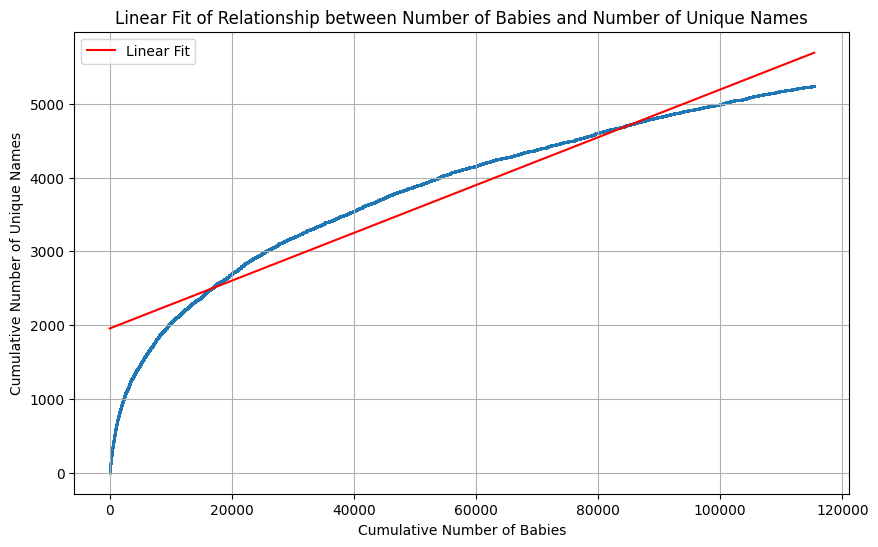

In [214]:
# Fit a linear model
linear_model = np.polyfit(cumulative_babies, cumulative_unique_names, 1)
linear_fit = np.polyval(linear_model, cumulative_babies)

plt.figure(figsize=(10, 6))
plt.scatter(cumulative_babies, cumulative_unique_names, s=1, alpha=0.5)
plt.plot(cumulative_babies, linear_fit, color='red', label='Linear Fit')
plt.xlabel('Cumulative Number of Babies')
plt.ylabel('Cumulative Number of Unique Names')
plt.title('Linear Fit of Relationship between Number of Babies and Number of Unique Names')
plt.legend()
plt.grid(True)
plt.show()



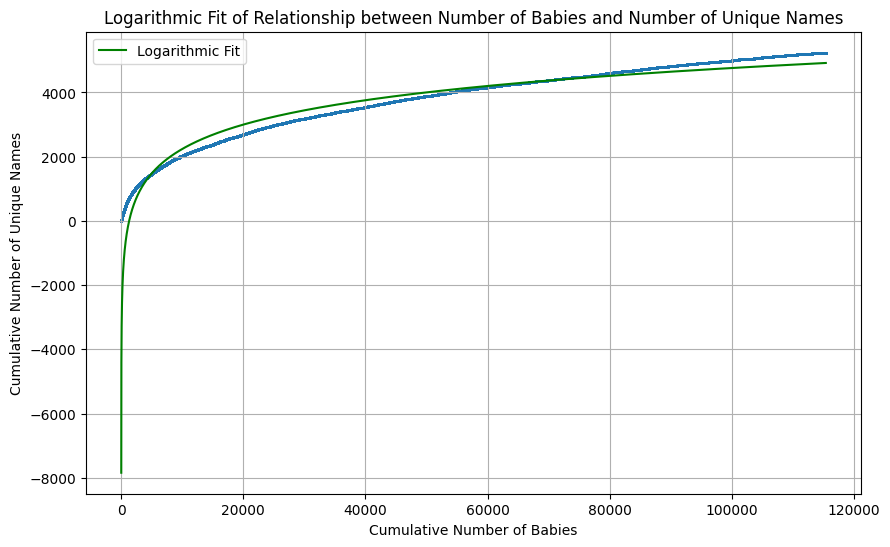

In [213]:
# Define a logarithmic function
def log_func(x, a, b):
    return a * np.log(x) + b

# Fit the logarithmic model
params, covariance = curve_fit(log_func, cumulative_babies, cumulative_unique_names)

# Plot the logarithmic fit
plt.figure(figsize=(10, 6))
plt.scatter(cumulative_babies, cumulative_unique_names, s=1, alpha=0.5)
plt.plot(cumulative_babies, log_func(cumulative_babies, *params), color='green', label='Logarithmic Fit')
plt.xlabel('Cumulative Number of Babies')
plt.ylabel('Cumulative Number of Unique Names')
plt.title('Logarithmic Fit of Relationship between Number of Babies and Number of Unique Names')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#echt het einde.... had een 30 tal minuten tekort. Gr, Sam